In [101]:
import sys
import os
import glob
import json
import pandas as pd
%matplotlib inline
import matplotlib
import numpy as np

In [102]:
def find_files(path):
    return glob.glob(path)

In [103]:
def read_json(filename):
    with open(filename) as json_file:
        data = json.load(json_file)
    return data

## Adatok olvasása
Adatok beolvasása JSON fájlként, majd egy nagy pandas-os DataFrame-mé alakítása.

In [104]:
json_data = []

for file in find_files('Data/*'):
    print("Reading file:", file)
    json_data.append(read_json(file))
    
data_frame = pd.DataFrame()

for data in json_data:
    frames  = [data_frame, pd.DataFrame(data)]
    data_frame = pd.concat(frames).reset_index(drop=True)

Reading file: Data/gyakori_szamitastechnika
Reading file: Data/gyakori_egeszseg_20000
Reading file: Data/gyakori_szorakozas_30000
Reading file: Data/gyakori_egeszseg
Reading file: Data/gyakori_allatok_14000


## Bepillantás a kérdésekbe
Csak hogy tudjuk pontosan mivel is állunk szemben. Minden kérdéshez tartozik a kérdés rövid, illetve hosszú verziója, egy válasz, amit a felhasználók a leghasznosabbnak találtak. Ezeken kívül kategóriák és kulcsszavak is vannak a kérdéshez.

In [105]:
data_frame.head(2)

,valasz,kategoriak,hosszu_kerdes,rovid_kerdes,keywords
0,Várak régen is voltak. Ha mindhárom tornyot le...,"[Számítástechnika, Internet]",Miért lett ilyen sz@r a honfoglaló? Régen tök ...,Miért lett ilyen sz@r a honfoglaló?,"[Honfoglaló, vár]"
1,"Ahogy írták, az stdio az a C-s függvénykönyvtá...","[Számítástechnika, Programozás]",C++-ban melyiket érdemesebb használni? Stdio v...,C++-ban melyiket érdemesebb használni? Stdio v...,"[C++, iostream, konzol, Windows, Visual Studio]"


A kategóriák közül csak a "főkategória" lényeges számunka, ezért a többit elhagyjuk.

In [106]:
data_frame['kategoriak'] = data_frame['kategoriak'].apply(lambda x: x[0])

## Átlagos hossz, extrém esetek szűrése
Az extrém hosszú vagy rövid kérdések nem túl hasznosak. Érdemes őket kiszűrni. Az átlagostól sokkal eltérő kérdéseket nem használjuk a továbbiakban.

In [107]:
def calculate_avg(data_frame, label="rovid_kerdes"):
    l = data_frame[label].tolist()
    return sum(map(len, l)) / len(l)

def drop_extreme(data_frame, min_, max_, label="rovid_kerdes"):
    data_frame = data_frame[data_frame[label].map(len) >= min_]
    data_frame = data_frame[data_frame[label].map(len) <= max_]

    return data_frame

In [108]:
long_questions_avg_len = calculate_avg(data_frame, "hosszu_kerdes")
print("Average length: %f" % long_questions_avg_len)

Average length: 346.495816


In [109]:
data_frame = drop_extreme(data_frame, long_questions_avg_len / 4, long_questions_avg_len * 3, "hosszu_kerdes")
long_questions_avg_len = calculate_avg(data_frame, "hosszu_kerdes")

print("Average length: %f" % long_questions_avg_len)

Average length: 326.753950


## "Főkategóriák" kigyűjtése
Az egyes főkategóriák neveinek kigyűjtése, majd az egyes nevekhez egy azonosító szám rendelése.

In [110]:
target_names = data_frame['kategoriak'].unique().tolist()
target_dict =  {value: key for key, value in enumerate(target_names)}

num_of_categories = len(target_names)

print(target_names)
print(target_dict)

['Számítástechnika', 'Egészség', 'Szórakozás', 'Állatok']
{'Számítástechnika': 0, 'Egészség': 1, 'Szórakozás': 2, 'Állatok': 3}


## Tanító adathalmaz előállítása
A tanító adathalmazban minden egyes főkategóriából ugyanannyi kérdésnek kell szerepelnie (így fair). Itt pontosan ez történik `questions_from_each_category` darab kérdés kerül a tanító adathalmazba minden kategóriából, majd az eredményül kapott tömb véletlenszerűen összekeveredik.

#### Shuffle together
A shuffle_together függvény két listát véletlenszerűen kever össze, úgy, hogy az a keverés előtt az egyes listákban azonos indexen szereplő értékek a keverés után is azonos indexen lesznek.

In [111]:
def shuffle_together(list1, list2):
    zipped = list(zip(list1, list2))
    random.shuffle(zipped)
    list1, list2 = zip(*zipped)
    
    return (list(list1), list(list2))

In [177]:
import random

train_each_ctg = 16000
train_size = train_each_ctg * num_of_categories
train_questions = []
train_target = []

test_each_ctg = 4000
test_size = test_each_ctg * num_of_categories
test_questions = []
test_target = []

# Shuffle rows
data_frame = data_frame.sample(frac=1).reset_index(drop=True)

for target_name in target_names:
    train_questions += data_frame[data_frame["kategoriak"] == target_name][0:train_each_ctg]["hosszu_kerdes"].to_list()
    train_target += [target_dict[target_name]] * train_each_ctg    
    
    test_questions += data_frame[data_frame["kategoriak"] == target_name][train_each_ctg:train_each_ctg + test_each_ctg]["hosszu_kerdes"].to_list()
    test_target += [target_dict[target_name]] * test_each_ctg    

train_questions, train_target = shuffle_together(train_questions, train_target)
test_questions, test_target = shuffle_together(test_questions, test_target)

In [178]:
def unicode_to_ascii(data):
    return unidecode.unidecode(re.sub(r"[,.;@#?!&$]+\ *", " ", data).lower()).split()

In [179]:
import unidecode
import re
from collections import Counter

unigram_vocab = set()
bigram_vocab = set()

for idx, q in enumerate(train_questions):
    words = unicode_to_ascii(q)

    for idx in range(len(words)):
        unigram_vocab.add(words[idx])
    for idx in range(len(words) - 1):
        bigram_vocab.add((words[idx], words[idx + 1]))

    train_questions[idx] = " ".join(words)

uni_total_words = len(unigram_vocab)
bi_total_words = len(bigram_vocab)

index_to_uni = {}
index_to_bi = {}

for idx, uni in enumerate(unigram_vocab):
    index_to_uni[uni] = idx

for idx, bi in enumerate(bigram_vocab):
    index_to_bi[bi] = idx

In [193]:
def get_batch(text, target, i, batch_size, input_size, index_to, ngram):

    batches = []
    results = []
    
    texts = text[i * batch_size : i * batch_size + batch_size]
    categories = target[i * batch_size : i * batch_size + batch_size]

    for text in texts:
        layer = np.zeros(input_size , dtype=float)
        words = unicode_to_ascii(text)
        
        if ngram == 1:
            for idx in range(len(words)):
                if words[idx] in index_to:
                    layer[index_to[words[idx]]] += 1
        else:
            for idx in range(len(words) - 1):
                if (words[idx], words[idx + 1]) in index_to:
                    layer[index_to[(words[idx], words[idx + 1])]] += 1
            
        batches.append(layer)
        
    for category in categories:
        results.append(category)
     
    return np.array(batches), np.array(results)

In [181]:
learning_rate = 0.01
num_epochs = 2
batch_size = 200

hidden_size = 100
input_size = uni_total_words
num_classes = len(target_names)

In [182]:
from torch.autograd import Variable
import torch.nn as nn
import torch

In [183]:
class BOWClassification(nn.Module):
     def __init__(self, input_size, hidden_size, num_classes):
        super(BOWClassification, self).__init__()
        self.layer_1 = nn.Linear(input_size, hidden_size, bias=True)
        self.relu = nn.ReLU()
        self.layer_2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear(hidden_size, num_classes, bias=True)
 
     def forward(self, x):
        out = self.layer_1(x)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.output_layer(out)
        return out

In [184]:
net = BOWClassification(uni_total_words, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  


for epoch in range(num_epochs):
    if epoch:
        print()
    print("Epoch %d/%d: " % (epoch + 1, num_epochs))
    total_batch = len(train_questions) // batch_size
    for i in range(total_batch):
        batch_x, batch_y = get_batch(train_questions, train_target, i, batch_size, uni_total_words, index_to_uni, 1)
        questions = Variable(torch.FloatTensor(batch_x))
        themes = Variable(torch.LongTensor(batch_y))
        
        optimizer.zero_grad()
        outputs = net(questions)
        loss = criterion(outputs, themes)
        loss.backward()
        optimizer.step()
        
        print("\r[%d/%d] %.2f%%" % (i + 1, total_batch, (i + 1)/ total_batch * 100), end="")

Epoch 1/2: 
[320/320] 100.00%
Epoch 2/2: 
[320/320] 100.00%

In [185]:
total_batch = test_size // batch_size

total_pred = []

for i in range(total_batch):
    test_batch_x, test_batch_y = get_batch(test_questions, test_target, i, batch_size, uni_total_words, index_to_uni, 1)
    print("\rTesting... [%d/%d] %.2f%%" % (i + 1, total_batch, (i + 1)/ total_batch * 100), end="")
    
    questions = Variable(torch.FloatTensor(test_batch_x))
    themes = Variable(torch.FloatTensor(test_batch_y))
    
    outputs = net(questions)
    _, predicted = torch.max(outputs.data, 1)
    total_pred += predicted.tolist()

Testing... [80/80] 100.00%

## Tesztelés eredémye

### Confusion matrix
Tévesztési mátrix magyarul. A mátrix `i` sorában, `j` oszlopában szereplő érték (ebben az esetben) azt jelenti, hogy a mondat a `i` kategóriájú, de a háló `j` kategóriát ismert fel.

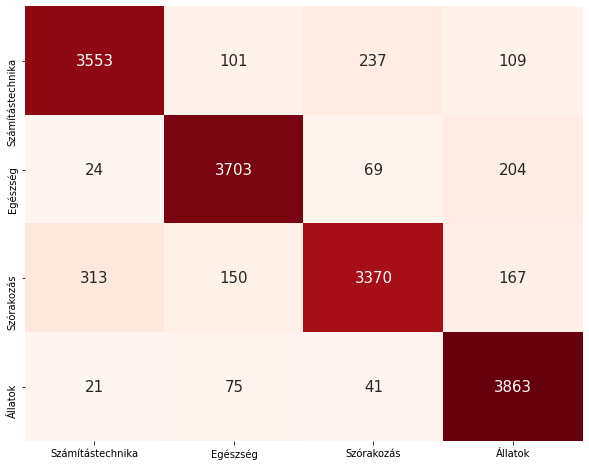

In [186]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

cm = confusion_matrix(test_target, total_pred)
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)

plt.figure(figsize = (10,8))
heatmap = sn.heatmap(cm_df, annot=True, cmap='Reds', fmt='g', annot_kws={"size": 15}, cbar=False)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

class_report = classification_report(test_target, total_pred, target_names=target_names)
print(class_report)